In [13]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
from random import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [14]:
env = BlackjackEnv()

In [87]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    p_greedy = 1 - epsilon + (epsilon/nA)
    p_explore = (epsilon/nA)
        
    def policy_fn(observation):
        action_values = Q[observation]
        greedy = np.argmax(action_values)
        
        return [p_greedy if i == greedy else p_explore for i,a in enumerate(action_values)]
        
        
    return policy_fn

In [111]:
def select_action(actions):
    r = random()
    action = -1
    total = 0
    for i, prob in enumerate(actions):
        if r < prob + total:
            action = i
            break
        total = total + prob
    assert action > -1
    
    return action

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode  in range(0, num_episodes):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        observation = env.reset()
        episode = [] # keep track of states visited
        for t in range(100):
            action_list = policy(observation)
            action = select_action(action_list)
            assert action > -1
            assert action < len(action_list)
            
            next_observation, reward, done, _ = env.step(action)
            # score, dealer_score, usable_ace = observation
            
            # save s_t, A_t, and R_{t+1}
            episode.append((observation, action, reward))
            
            if done:
                # The final state is of no interest, only the final reward.
                break
            
            observation = next_observation
        
        # update Q, from page 101:
        G = 0    
        visited_states = set()
        for (state, action, reward) in reversed(episode):
            # this only works if discount == 1
            G = discount_factor*G + reward
            if (state, action) not in visited_states: # first visit only
                s_a = (state, action)
                returns_sum[s_a] = returns_sum[s_a] + G
                returns_count[s_a] = returns_count[s_a] + 1
                
                Q[state][action] = returns_sum[s_a]/returns_count[s_a]
                visited_states.add(s_a)
                
    
    return Q, policy

In [114]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

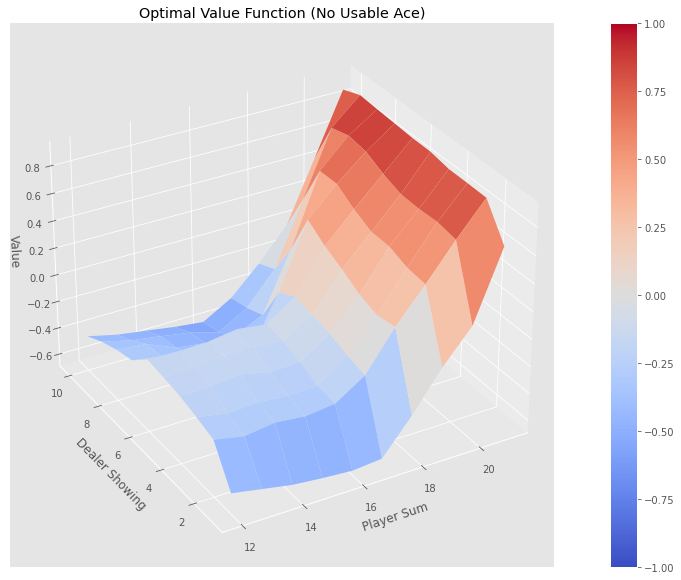

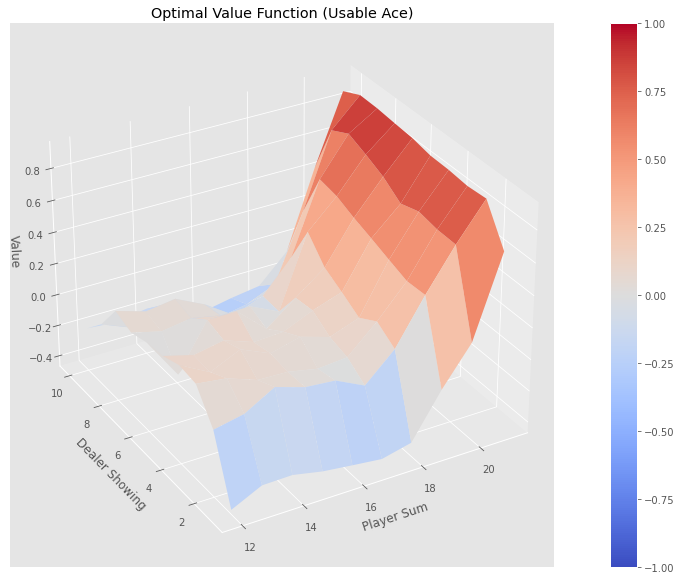

In [115]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")